# Φόρτωση Βιβλιοθηκών και Βοηθητικών Συναρτήσεων

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

Helper function for Learning Curves:

In [14]:
def training_metric(model, X, y, scoring_func, n_splits=5, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Υπολογίζει τις τιμές του metric (π.χ., accuracy, f1, precision, recall) 
    για διάφορα μεγέθη του training set, χρησιμοποιώντας Stratified K-Fold.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_scores = []
    val_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        fold_train_scores = []
        fold_val_scores = []
        for train_size in train_sizes:
            subset_size = int(len(X_train_fold) * train_size)
            X_train_subset = X_train_fold[:subset_size]
            y_train_subset = y_train_fold[:subset_size]
            model.fit(X_train_subset, y_train_subset)
            y_train_pred = model.predict(X_train_subset)
            y_val_pred = model.predict(X_val_fold)
            fold_train_scores.append(scoring_func(y_train_subset, y_train_pred))
            fold_val_scores.append(scoring_func(y_val_fold, y_val_pred))
        train_scores.append(fold_train_scores)
        val_scores.append(fold_val_scores)
    train_scores_mean = np.mean(train_scores, axis=0)
    val_scores_mean = np.mean(val_scores, axis=0)
    return train_scores_mean, val_scores_mean, train_sizes


### Φόρτωση και Προεπεξεργασία του IMDB Dataset

- `num_words` : το πλήθος του λεξιλογίου
- `skip_top` : ο αριθμός των πιο συχνών λέξεων που αγνοούμε
- `max_len` : το μέγιστο πλήθος ενός δείγματος/review

In [15]:
def load_and_preprocess_imdb(num_words=10000, skip_top=20, maxlen=200):
    # Φορτώνουμε το dataset
    (x_train, y_train), (x_val, y_val) = imdb.load_data(num_words=num_words, skip_top=skip_top)
    
    # Μετατροπή σε δυαδική αναπαράσταση (bag-of-words)
    def to_binary_vector(sequences, vocab_size):
        binary_matrix = np.zeros((len(sequences), vocab_size))
        for i, sequence in enumerate(sequences):
            for index in sequence:
                if index < vocab_size:
                    binary_matrix[i, index] = 1
        return binary_matrix

    x_train = to_binary_vector(x_train, num_words)
    x_val = to_binary_vector(x_val, num_words)
    
    # Εξασφάλιση ομοιόμορφου μήκους
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
    x_val = pad_sequences(x_val, maxlen=maxlen, padding='post', truncating='post')
    
    return x_train, y_train, x_val, y_val

# Φόρτωση δεδομένων (π.χ., αρχικές τιμές)
x_train, y_train, x_val, y_val = load_and_preprocess_imdb(num_words=10000, skip_top=20, maxlen=200)


# Υλοποίηση του Custom AdaBoost (με Decision Stumps)

In [16]:
class AdaBoost:
    def __init__(self, n_estimators=10, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators = []  # Λίστα weak classifiers (decision stumps)
        self.alphas = []      # Βάρη για κάθε weak classifier

    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "random_state": self.random_state}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def fit(self, X, y):
        """
        Εκπαίδευση του AdaBoost:
          - Τα labels y είναι {0,1} και μετατρέπονται σε {-1, +1}.
          - Χρησιμοποιούμε DecisionTreeClassifier με max_depth=1 (decision stump).
        """
        y_mapped = np.where(y == 0, -1, 1)  # 0 -> -1, 1 -> +1
        n_samples = X.shape[0]
        sample_weights = np.ones(n_samples) / n_samples

        self.estimators = []
        self.alphas = []
        
        for i in range(self.n_estimators):
            stump = DecisionTreeClassifier(
                max_depth=1,
                criterion="entropy",
                random_state=(self.random_state + i) if self.random_state is not None else None
            )
            stump.fit(X, y, sample_weight=sample_weights)
            y_pred = stump.predict(X)
            y_pred_mapped = np.where(y_pred == 0, -1, 1)
            
            error = np.sum(sample_weights * (y_pred_mapped != y_mapped)) / np.sum(sample_weights)
            if error == 0:
                error = 1e-10  # Αποφυγή διαιρέσεως με το 0
            if error >= 0.5:
                continue  # Παράβλεψη του classifier αν το error δεν είναι καλύτερο από τυχαία επιλογή
            
            alpha = 0.5 * np.log((1 - error) / error)
            self.estimators.append(stump)
            self.alphas.append(alpha)
            
            sample_weights *= np.exp(-alpha * y_mapped * y_pred_mapped)
            sample_weights /= np.sum(sample_weights)

    def predict(self, X):
        """
        Συνδυάζει τις προβλέψεις των weak classifiers βάσει των βαρών τους.
        Επιστρέφει τις τελικές προβλέψεις σε {0,1}.
        """
        agg = np.zeros(X.shape[0])
        for alpha, stump in zip(self.alphas, self.estimators):
            y_pred = stump.predict(X)
            y_pred_mapped = np.where(y_pred == 0, -1, 1)
            agg += alpha * y_pred_mapped
        return np.where(agg >= 0, 1, 0)


### Εκπαίδευση και Αξιολόγηση του Custom AdaBoost Μοντέλου

#### Δημιουργία και εκπαίδευση του μοντέλου με 10 weak classifiers

In [17]:
ada = AdaBoost(n_estimators=10, random_state=42)
ada.fit(x_train, y_train)
ada_predictions = ada.predict(x_val)

#### Υπολογισμός μετρικών

In [18]:
ada_accuracy = accuracy_score(y_val, ada_predictions)
ada_precision = precision_score(y_val, ada_predictions, pos_label=1, zero_division=0)
ada_recall = recall_score(y_val, ada_predictions, pos_label=1, zero_division=0)
ada_f1 = f1_score(y_val, ada_predictions, pos_label=1, zero_division=0)

print("Custom AdaBoost Evaluation Metrics:")
print(f"Accuracy: {ada_accuracy*100:.2f}%")
print(f"Precision: {ada_precision:.2f}")
print(f"Recall: {ada_recall:.2f}")
print(f"F1 Score: {ada_f1:.2f}")

Custom AdaBoost Evaluation Metrics:
Accuracy: 67.98%
Precision: 0.72
Recall: 0.60
F1 Score: 0.65


#### Confusion Matrix

Confusion Matrix:
[[9532 2968]
 [5036 7464]]


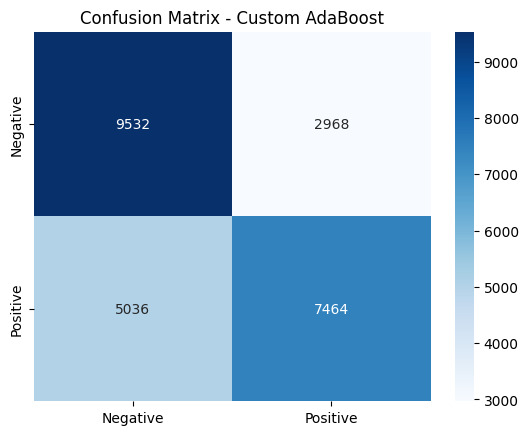

In [19]:
cm_ada = confusion_matrix(y_val, ada_predictions, labels=[0, 1])
print("Confusion Matrix:")
print(cm_ada)
sns.heatmap(cm_ada, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - Custom AdaBoost")
plt.show()

### Επιλογή υπερ-παραμέτρων με random-sampling

In [9]:
param_grid = {
    "num_words": [5000, 10000, 20000],
    "skip_top": [0, 20, 50],
    "maxlen": [100, 200, 300],
    "num_classifiers": [10, 50, 100]
}

import itertools
from random import sample

def generate_random_combinations(param_grid, num_samples=20):
    all_combinations = list(itertools.product(*param_grid.values()))
    return sample(all_combinations, num_samples)

def load_and_preprocess_data(num_words, skip_top, maxlen):
    return load_and_preprocess_imdb(num_words=num_words, skip_top=skip_top, maxlen=maxlen)

def evaluate_configuration(config):
    num_words, skip_top, maxlen, num_classifiers = config
    x_tr, y_tr, x_va, y_va = load_and_preprocess_data(num_words, skip_top, maxlen)
    ada_temp = AdaBoost(n_estimators=num_classifiers, random_state=42)
    ada_temp.fit(x_tr, y_tr)
    y_pred_temp = ada_temp.predict(x_va)
    return accuracy_score(y_va, y_pred_temp)

def random_search(param_grid, num_samples=20):
    random_combinations = generate_random_combinations(param_grid, num_samples)
    best_config = None
    best_accuracy = 0.0
    print(f"Testing {num_samples} random configurations for Custom AdaBoost...")
    for i, config in enumerate(random_combinations):
        print(f"\nTesting configuration {i+1}/{num_samples}: {config}")
        acc = evaluate_configuration(config)
        print(f"Accuracy: {acc:.4f}")
        if acc > best_accuracy:
            best_accuracy = acc
            best_config = config
    return best_config, best_accuracy

best_config, best_accuracy = random_search(param_grid, num_samples=20)
print("\nBest Hyperparameter Configuration (Custom AdaBoost):")
print(f"num_words: {best_config[0]}, skip_top: {best_config[1]}, maxlen: {best_config[2]}, num_classifiers: {best_config[3]}")
print(f"Validation Accuracy: {best_accuracy:.4f}")

Testing 20 random configurations for Custom AdaBoost...

Testing configuration 1/20: (10000, 20, 200, 50)
Accuracy: 0.7283

Testing configuration 2/20: (5000, 50, 300, 50)
Accuracy: 0.7381

Testing configuration 3/20: (20000, 0, 100, 50)
Accuracy: 0.6986

Testing configuration 4/20: (20000, 50, 300, 10)
Accuracy: 0.6883

Testing configuration 5/20: (5000, 50, 300, 100)
Accuracy: 0.7616

Testing configuration 6/20: (5000, 50, 100, 100)
Accuracy: 0.6942

Testing configuration 7/20: (20000, 20, 300, 50)
Accuracy: 0.7432

Testing configuration 8/20: (10000, 0, 100, 50)
Accuracy: 0.6997

Testing configuration 9/20: (20000, 0, 100, 10)
Accuracy: 0.6715

Testing configuration 10/20: (5000, 0, 200, 10)
Accuracy: 0.6798

Testing configuration 11/20: (20000, 50, 100, 10)
Accuracy: 0.6658

Testing configuration 12/20: (5000, 50, 300, 10)
Accuracy: 0.6883

Testing configuration 13/20: (20000, 20, 100, 100)
Accuracy: 0.7038

Testing configuration 14/20: (10000, 50, 300, 10)
Accuracy: 0.6883

Testin

### Τελική Εκπαίδευση με τις Καλύτερες Παραμέτρους και Σύγκριση με scikit‑learn AdaBoost

### Καλύτερος συνδυασμός υπερ-παραμέτρων: 

```num_words: 5000, skip_top: 50, maxlen: 300, num_classifiers: 100```

In [10]:
num_words = 5000 
skip_top = 50 
maxlen = 300
num_classifiers = 100

x_tr, y_tr, x_va, y_va = load_and_preprocess_data(num_words, skip_top, maxlen)

#### Εκπαίδευση του custom AdaBoost με τις καλύτερες παραμέτρους

Final Custom AdaBoost Evaluation:
Accuracy: 0.76
Precision: 0.75
Recall: 0.79
F1 Score: 0.77


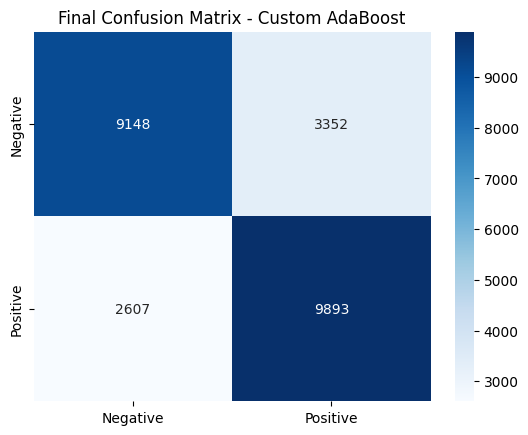

In [11]:
ada_final = AdaBoost(n_estimators=num_classifiers, random_state=42)
ada_final.fit(x_tr, y_tr)
y_pred_final = ada_final.predict(x_va)

final_accuracy = accuracy_score(y_va, y_pred_final)
final_precision = precision_score(y_va, y_pred_final, pos_label=1, zero_division=0)
final_recall = recall_score(y_va, y_pred_final, pos_label=1, zero_division=0)
final_f1 = f1_score(y_va, y_pred_final, pos_label=1, zero_division=0)

print("Final Custom AdaBoost Evaluation:")
print(f"Accuracy: {final_accuracy:.2f}")
print(f"Precision: {final_precision:.2f}")
print(f"Recall: {final_recall:.2f}")
print(f"F1 Score: {final_f1:.2f}")

cm_final = confusion_matrix(y_va, y_pred_final, labels=[0, 1])
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Final Confusion Matrix - Custom AdaBoost")
plt.show()

#### Καμπύλες μάθησης για το Custom AdaBoost

In [20]:
best_custom_ada = AdaBoost(n_estimators=num_classifiers, random_state=42)

##### Learning Curve - F1 Score (for positive)

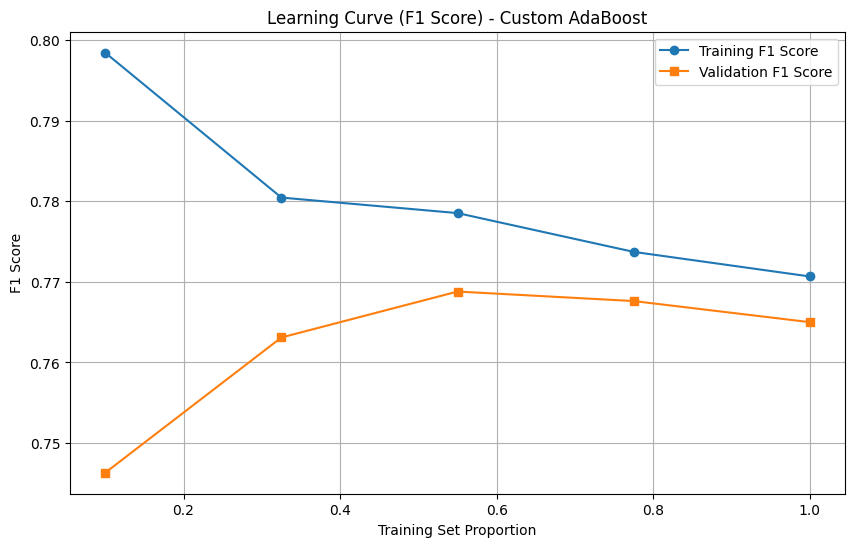

In [21]:
train_scores_f1, val_scores_f1, train_sizes = training_metric(best_custom_ada, x_tr, y_tr, scoring_func=f1_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_f1, label="Training F1 Score", marker="o")
plt.plot(train_sizes, val_scores_f1, label="Validation F1 Score", marker="s")
plt.title("Learning Curve (F1 Score) - Custom AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Accuracy (for positive)

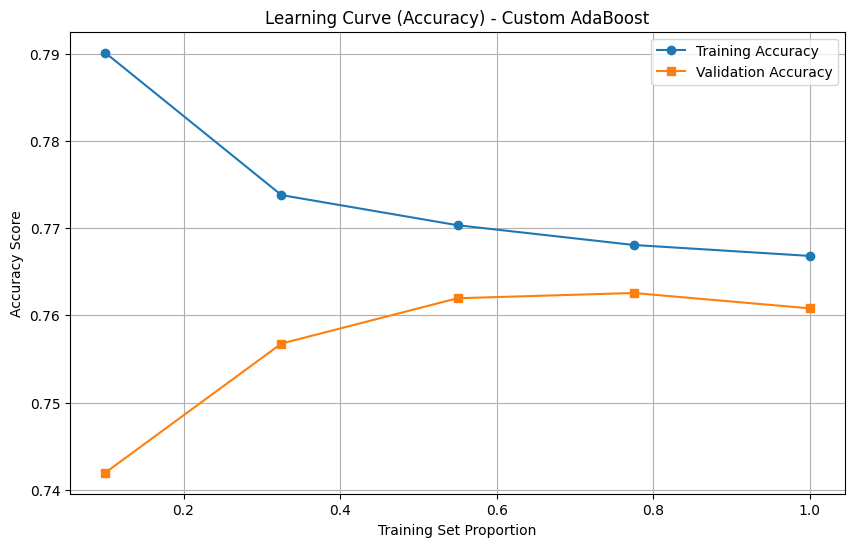

In [22]:
train_scores_acc, val_scores_acc, train_sizes = training_metric(best_custom_ada, x_tr, y_tr, scoring_func=accuracy_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_acc, label="Training Accuracy", marker="o")
plt.plot(train_sizes, val_scores_acc, label="Validation Accuracy", marker="s")
plt.title("Learning Curve (Accuracy) - Custom AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Precision (for positive)

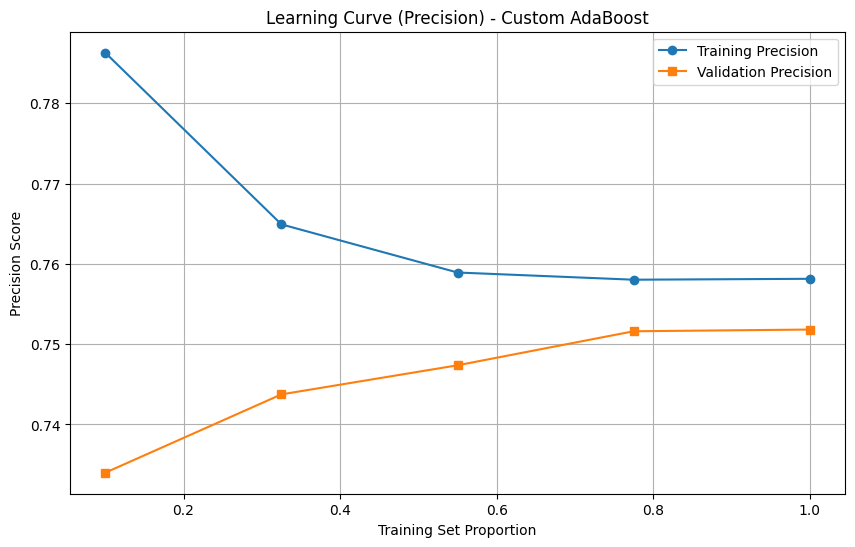

In [23]:
train_scores_prec, val_scores_prec, train_sizes = training_metric(best_custom_ada, x_tr, y_tr, scoring_func=precision_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_prec, label="Training Precision", marker="o")
plt.plot(train_sizes, val_scores_prec, label="Validation Precision", marker="s")
plt.title("Learning Curve (Precision) - Custom AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Precision Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Recall (for positive)

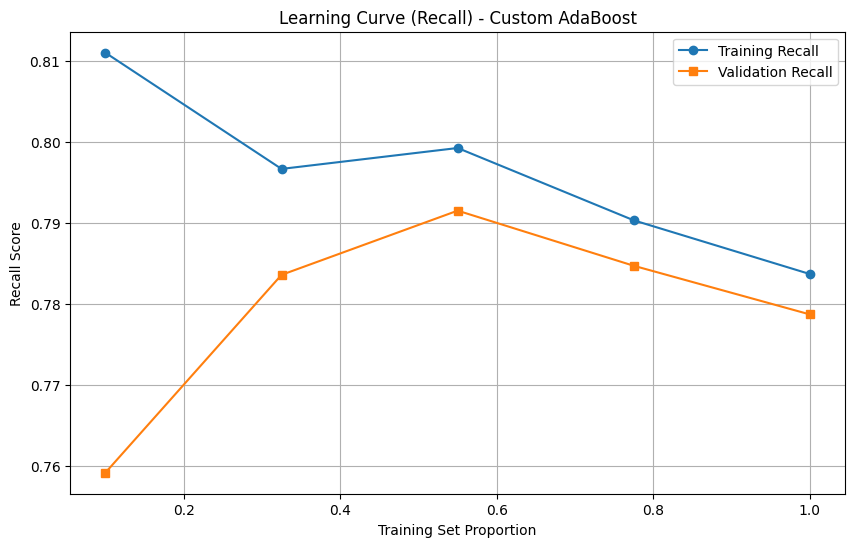

In [24]:
train_scores_rec, val_scores_rec, train_sizes = training_metric(best_custom_ada, x_tr, y_tr, scoring_func=recall_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_rec, label="Training Recall", marker="o")
plt.plot(train_sizes, val_scores_rec, label="Validation Recall", marker="s")
plt.title("Learning Curve (Recall) - Custom AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()

#### Καμπύλες μάθησης για το scikit‑learn AdaBoost

In [26]:
base_estimator = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=42)
sk_ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=100, random_state=42)

##### Learning Curve - F1 Score (for positive)

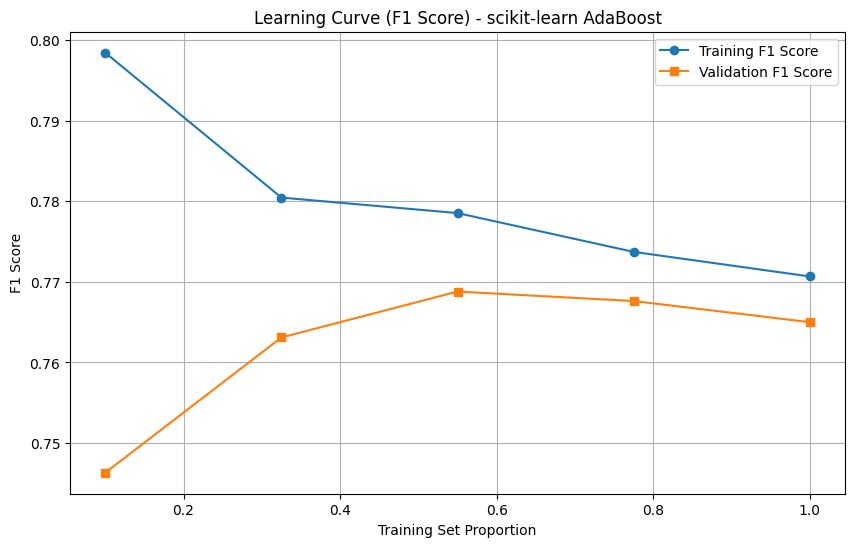

In [27]:
train_scores_f1_sk, val_scores_f1_sk, train_sizes_sk = training_metric(sk_ada_model, x_tr, y_tr, scoring_func=f1_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes_sk, train_scores_f1_sk, label="Training F1 Score", marker="o")
plt.plot(train_sizes_sk, val_scores_f1_sk, label="Validation F1 Score", marker="s")
plt.title("Learning Curve (F1 Score) - scikit‑learn AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Accuracy (for positive)

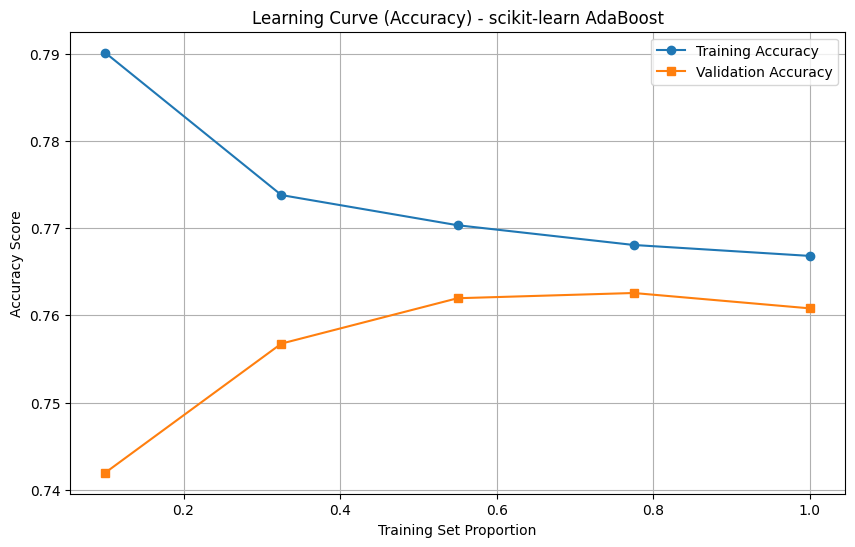

In [28]:
train_scores_acc_sk, val_scores_acc_sk, train_sizes_sk = training_metric(sk_ada_model, x_tr, y_tr, scoring_func=accuracy_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes_sk, train_scores_acc_sk, label="Training Accuracy", marker="o")
plt.plot(train_sizes_sk, val_scores_acc_sk, label="Validation Accuracy", marker="s")
plt.title("Learning Curve (Accuracy) - scikit‑learn AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Precision (for positive)

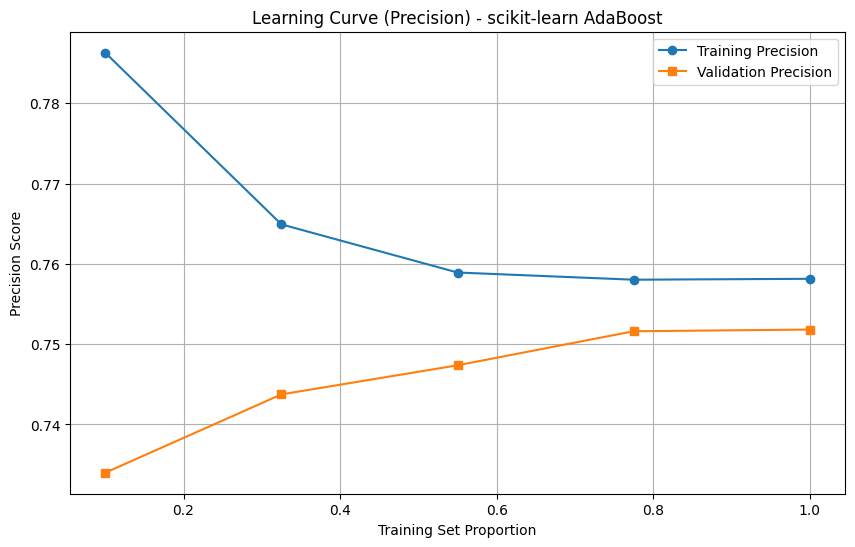

In [29]:
train_scores_prec_sk, val_scores_prec_sk, train_sizes_sk = training_metric(sk_ada_model, x_tr, y_tr, scoring_func=precision_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes_sk, train_scores_prec_sk, label="Training Precision", marker="o")
plt.plot(train_sizes_sk, val_scores_prec_sk, label="Validation Precision", marker="s")
plt.title("Learning Curve (Precision) - scikit‑learn AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Precision Score")
plt.legend()
plt.grid()
plt.show()

##### Learning Curve - Recall (for positive)

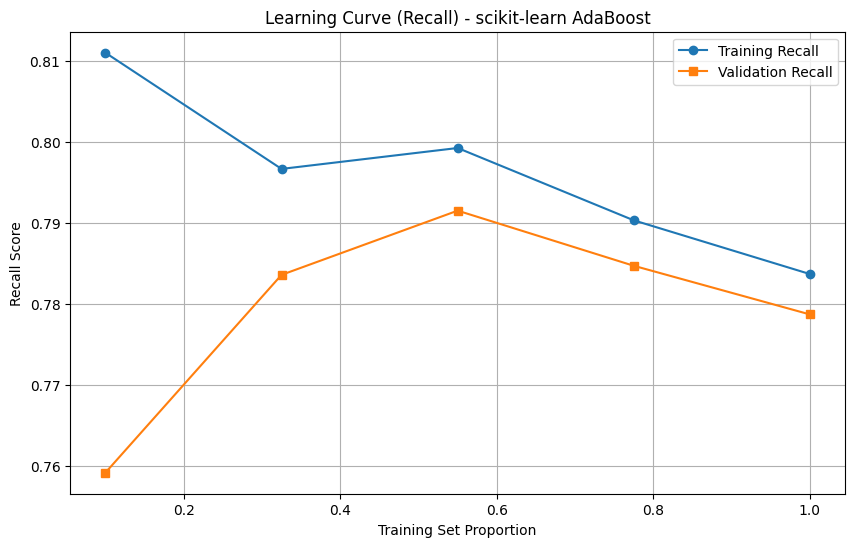

In [30]:
train_scores_rec_sk, val_scores_rec_sk, train_sizes_sk = training_metric(sk_ada_model, x_tr, y_tr, scoring_func=recall_score)
plt.figure(figsize=(10,6))
plt.plot(train_sizes_sk, train_scores_rec_sk, label="Training Recall", marker="o")
plt.plot(train_sizes_sk, val_scores_rec_sk, label="Validation Recall", marker="s")
plt.title("Learning Curve (Recall) - scikit‑learn AdaBoost")
plt.xlabel("Training Set Proportion")
plt.ylabel("Recall Score")
plt.legend()
plt.grid()
plt.show()

# Σύγκριση με scikit-learn AdaBoost

scikit‑learn AdaBoost Evaluation:
Accuracy: 0.76
Precision: 0.75
Recall: 0.79
F1 Score: 0.77


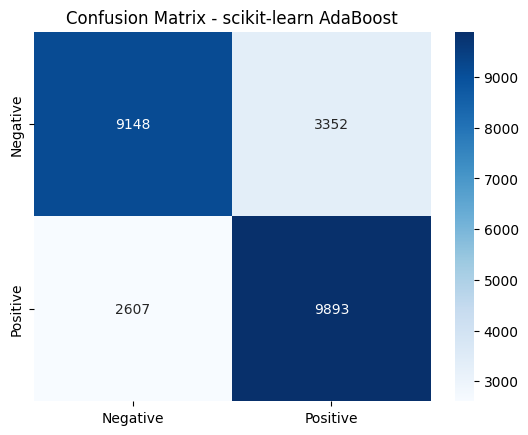

In [31]:
base_estimator = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=42)
sk_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=num_classifiers, random_state=42)
sk_model.fit(x_tr, y_tr)
sk_y_pred = sk_model.predict(x_va)

sk_accuracy = accuracy_score(y_va, sk_y_pred)
sk_precision = precision_score(y_va, sk_y_pred, pos_label=1, zero_division=0)
sk_recall = recall_score(y_va, sk_y_pred, pos_label=1, zero_division=0)
sk_f1 = f1_score(y_va, sk_y_pred, pos_label=1, zero_division=0)

print("scikit‑learn AdaBoost Evaluation:")
print(f"Accuracy: {sk_accuracy:.2f}")
print(f"Precision: {sk_precision:.2f}")
print(f"Recall: {sk_recall:.2f}")
print(f"F1 Score: {sk_f1:.2f}")

cm_sk = confusion_matrix(y_va, sk_y_pred, labels=[0, 1])
sns.heatmap(cm_sk, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - scikit‑learn AdaBoost")
plt.show()

### Μέρος Γ’: Στοιβαγμένο Διπλής Κατεύθυνσης LSTM με Global Max Pooling

#### Εισαγωγή Βιβλιοθηκών

In [32]:
# Εισαγωγή των απαραίτητων βιβλιοθηκών και ρύθμιση της συσκευής (GPU/CPU)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import gensim.downloader as api

# Έλεγχος για GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Χρήση συσκευής:", device)

Χρήση συσκευής: cpu


#### Προεπεξεργασία Δεδομένων

In [33]:
# Συνάρτηση για την προεπεξεργασία του dataset των 20 Newsgroups (δυαδική ταξινόμηση)
def preprocess_newsgroups(categories, max_features=10000):
    """
    Φορτώνει το dataset 20 Newsgroups για τις κατηγορίες που δίνονται, 
    δημιουργεί λεξιλόγιο με CountVectorizer και επιστρέφει ακολουθίες (padded) 
    μαζί με τις ετικέτες.
    """
    newsgroups = fetch_20newsgroups(subset='all', categories=categories,
                                    remove=('headers','footers','quotes'))
    texts, labels = newsgroups.data, newsgroups.target
    
    # Διαχωρισμός δεδομένων: εκπαίδευση, ανάπτυξη (validation) και τεστ
    X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Δημιουργία λεξιλογίου με CountVectorizer (μέγιστο 10,000 χαρακτηριστικά)
    vectorizer = CountVectorizer(max_features=max_features)
    vectorizer.fit(X_train)
    base_vocab = vectorizer.vocabulary_
    
    # Δημιουργία λεξιλογίου με κράτηση ειδικών tokens ('PAD' και 'UNK')
    # Μετατοπίζουμε τους δείκτες κατά 2, ώστε να έχουμε 0 για PAD και 1 για UNK.
    vocab = {word: (idx + 2) for word, idx in base_vocab.items()}
    vocab['PAD'] = 0
    vocab['UNK'] = 1
    vocab_size = len(vocab)
    print("Μέγεθος λεξιλογίου:", vocab_size)
    
    # Συνάρτηση tokenization (αφαίρεση μη αλφαβητικών χαρακτήρων)
    def tokenize(text):
        text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
        return text.split()
    
    # Μετατροπή κειμένου σε ακολουθία ακεραίων
    def text_to_sequence(text):
        tokens = tokenize(text)
        return [vocab.get(token, vocab['UNK']) for token in tokens]
    
    X_train_seq = [text_to_sequence(text) for text in X_train]
    X_val_seq   = [text_to_sequence(text) for text in X_val]
    X_test_seq  = [text_to_sequence(text) for text in X_test]
    
    # Καθορισμός σταθερού μήκους ακολουθίας (μέσος όρος μήκους εκπαίδευσης)
    avg_len = int(np.mean([len(seq) for seq in X_train_seq]))
    print("Μέσο μήκος ακολουθίας:", avg_len)
    
    # Συνάρτηση για padding
    def pad_sequence(seq, max_len):
        if len(seq) < max_len:
            return seq + [vocab['PAD']] * (max_len - len(seq))
        else:
            return seq[:max_len]
    
    max_len = avg_len  # ή ορίστε ένα σταθερό αριθμό
    X_train_pad = [pad_sequence(seq, max_len) for seq in X_train_seq]
    X_val_pad   = [pad_sequence(seq, max_len) for seq in X_val_seq]
    X_test_pad  = [pad_sequence(seq, max_len) for seq in X_test_seq]
    
    # Μετατροπή λιστών σε torch tensors
    X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor   = torch.tensor(X_val_pad, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    X_test_tensor  = torch.tensor(X_test_pad, dtype=torch.long)
    y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    
    return (X_train_tensor, y_train_tensor, 
            X_val_tensor, y_val_tensor, 
            X_test_tensor, y_test_tensor, vocab, vocab_size, max_len)

# Εκτέλεση προεπεξεργασίας για τις κατηγορίες που επιλέγουμε
categories = ['comp.graphics', 'sci.space']
X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, vocab, vocab_size, max_len = preprocess_newsgroups(categories)

# Δημιουργία DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


Μέγεθος λεξιλογίου: 10002
Μέσο μήκος ακολουθίας: 185


#### Δημιουργία Ενσωματώσεων

In [34]:
# Συνάρτηση για δημιουργία πίνακα ενσωματώσεων χρησιμοποιώντας τις προ-εκπαιδευμένες ενσωματώσεις Word2Vec.
def build_embedding_matrix(vocab, vocab_size, embed_dim=300):
    # Φόρτωση προ-εκπαιδευμένων ενσωματώσεων (Google News Word2Vec)
    word2vec = api.load('word2vec-google-news-300')
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    average_embedding = np.mean(word2vec.vectors, axis=0)
    for word, idx in vocab.items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            embedding_matrix[idx] = average_embedding
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 300
embedding_matrix = build_embedding_matrix(vocab, vocab_size, embed_dim=embedding_dim)


#### Ορισμός του Μοντέλου - Stacked Bidirectional LSTM με Global Max Pooling

In [35]:
class StackedBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(StackedBiLSTM, self).__init__()
        # Ενσωματωματική στρώση με προ-εκπαιδευμένες ενσωματώσεις
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        # Στρωματοποιημένο bidirectional LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)
        # Global max pooling και τελικό πλήρως συνδεδεμένο στρώμα
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)              # (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.lstm(embedded)           # (batch_size, seq_len, hidden_dim*2)
        pooled, _ = torch.max(lstm_out, dim=1)       # (batch_size, hidden_dim*2)
        logits = self.fc(pooled)                    # (batch_size, output_dim)
        return torch.sigmoid(logits)

# Ορισμός παραμέτρων του μοντέλου
hidden_dim = 64
num_layers = 2
dropout = 0.5

# Εγκατάσταση του μοντέλου
model = StackedBiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim=1,
                      num_layers=num_layers, dropout=dropout)
model = model.to(device)
print(model)


StackedBiLSTM(
  (embedding): Embedding(10002, 300)
  (lstm): LSTM(300, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


#### Εκπαίδευση του Μοντέλου και Καμπύλες Απώλειας

Εποχή 1/10 - Απώλεια Εκπαίδευσης: 0.6725, Απώλεια Ανάπτυξης: 0.5577
Εποχή 2/10 - Απώλεια Εκπαίδευσης: 0.3548, Απώλεια Ανάπτυξης: 0.3088
Εποχή 3/10 - Απώλεια Εκπαίδευσης: 0.1623, Απώλεια Ανάπτυξης: 0.2366
Εποχή 4/10 - Απώλεια Εκπαίδευσης: 0.1006, Απώλεια Ανάπτυξης: 0.2769
Εποχή 5/10 - Απώλεια Εκπαίδευσης: 0.0795, Απώλεια Ανάπτυξης: 0.2530
Εποχή 6/10 - Απώλεια Εκπαίδευσης: 0.0380, Απώλεια Ανάπτυξης: 0.2133
Εποχή 7/10 - Απώλεια Εκπαίδευσης: 0.0336, Απώλεια Ανάπτυξης: 0.2776
Εποχή 8/10 - Απώλεια Εκπαίδευσης: 0.0312, Απώλεια Ανάπτυξης: 0.2827
Εποχή 9/10 - Απώλεια Εκπαίδευσης: 0.0299, Απώλεια Ανάπτυξης: 0.2783
Εποχή 10/10 - Απώλεια Εκπαίδευσης: 0.0254, Απώλεια Ανάπτυξης: 0.2622
Καλύτερη απώλεια ανάπτυξης στην εποχή 6: 0.2133


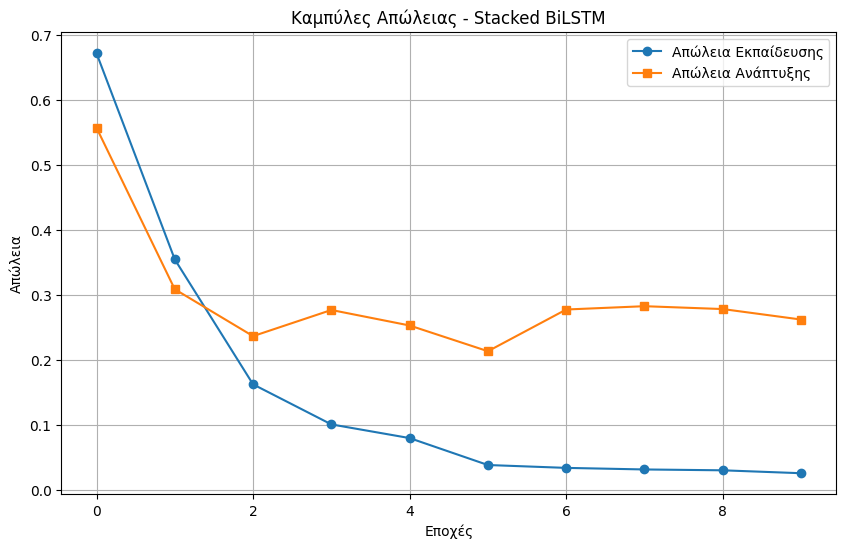

In [36]:
# Συνάρτηση εκπαίδευσης που καταγράφει τις απώλειες εκπαίδευσης και ανάπτυξης ανά εποχή.
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_epoch = -1
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
        
        print(f"Εποχή {epoch+1}/{num_epochs} - Απώλεια Εκπαίδευσης: {avg_train_loss:.4f}, Απώλεια Ανάπτυξης: {avg_val_loss:.4f}")
        
    print(f"Καλύτερη απώλεια ανάπτυξης στην εποχή {best_epoch+1}: {best_val_loss:.4f}")
    return train_losses, val_losses

# Ορισμός συνάρτησης απώλειας και optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Εκπαίδευση του μοντέλου
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

# Σχεδίαση καμπυλών απώλειας
plt.figure(figsize=(10,6))
plt.plot(train_losses, label="Απώλεια Εκπαίδευσης", marker='o')
plt.plot(val_losses, label="Απώλεια Ανάπτυξης", marker='s')
plt.xlabel("Εποχές")
plt.ylabel("Απώλεια")
plt.title("Καμπύλες Απώλειας - Stacked BiLSTM")
plt.legend()
plt.grid(True)
plt.show()


#### Αξιολόγηση του Μοντέλου σε Δεδομένα Τεστ

In [37]:
# Συνάρτηση αξιολόγησης που συγκεντρώνει τις προβλέψεις και επιστρέφει τις ετικέτες
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels).flatten(), np.array(all_preds).flatten()

y_true, y_pred = evaluate_model(model, test_loader)
print("Αποτελέσματα Αξιολόγησης σε Δεδομένα Τεστ:")
print(classification_report(y_true, y_pred, target_names=["Κατηγορία 0", "Κατηγορία 1"]))


Αποτελέσματα Αξιολόγησης σε Δεδομένα Τεστ:
              precision    recall  f1-score   support

 Κατηγορία 0       0.95      0.93      0.94       137
 Κατηγορία 1       0.94      0.96      0.95       157

    accuracy                           0.95       294
   macro avg       0.95      0.94      0.95       294
weighted avg       0.95      0.95      0.95       294

